### OceanHackWeek2022: ENSO Prediction Using Deep Learning

The El Niño-Southern Oscillation (ENSO) is a recurring climate pattern involving changes in the temperature of waters in the central and eastern tropical Pacific Ocean. Overall, the current forecast models can provide effective predictions of ENSO warm and cold events 6–12 months ahead. 

In [2]:
# import necessary packages
import numpy as np
import xarray as xr
from tensorflow import keras

In [3]:
# import deep learning libraries
import tensorflow as tf
from tensorflow import keras

In [4]:
# merging all files into one dataset
member_id_list = ['r10i1181p1f1', 'r1i1001p1f1','r2i1021p1f1','r3i1041p1f1','r4i1061p1f1',
                  'r5i1081p1f1','r6i1101p1f1','r7i1121p1f1','r8i1141p1f1','r9i1161p1f1']

In [5]:
merged_dataset_all_members = []
for i in range(len(member_id_list)):
    
    filename = '~/ENSO_SST/ENSO_Project_SST_{}.nc'.format(member_id_list[i])
    SST_member = xr.open_dataset(filename)
    
    filename = '~/ENSO_SSH/ENSO_Project_SSH_{}.nc'.format(member_id_list[i])
    SSH_member = xr.open_dataset(filename)

    filename = '~/ENSO_PRECT/ENSO_Project_PRECT_{}.nc'.format(member_id_list[i])
    PRECT_member = xr.open_dataset(filename)

    filename = '~/ENSO_SLP/ENSO_Project_PSL_{}.nc'.format(member_id_list[i])
    SLP_member = xr.open_dataset(filename)

    filename = '~/ENSO_U10/ENSO_Project_U10_{}.nc'.format(member_id_list[i])
    U10_member = xr.open_dataset(filename)
    
    merged_dataset = xr.merge([SST_member, PRECT_member, SLP_member, U10_member]).load()
    merged_dataset_all_members.append(merged_dataset)

In [6]:
print(len(merged_dataset_all_members))
merged_dataset_all_members[0] # let us see what one looks like

10


<xarray.Dataset>
Dimensions:    (lat: 64, lon: 96, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.06 -86.23 -83.4 -80.58 ... 83.4 86.23 89.06
  * lon        (lon) float64 1.25 5.0 8.75 12.5 ... 346.2 350.0 353.8 357.5
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    member_id  <U12 'r10i1181p1f1'
Data variables:
    SST        (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 271.4 271.4 271.4
    PRECT      (time, lat, lon) float32 1.294e-09 1.321e-09 ... 4.94e-09
    PSL        (time, lat, lon) float32 1.011e+05 1.011e+05 ... 1.005e+05
    U10        (time, lat, lon) float32 5.724 5.693 5.658 ... 5.519 5.535 5.549

In [7]:
NINO34all = []
SST_a_all = []

for i in range(len(merged_dataset_all_members)):
    # calculate anomalies
    SST_clim=merged_dataset_all_members[i].SST.groupby("time.month").mean('time')  #climatology
    SST_a = merged_dataset_all_members[i].SST.groupby("time.month")-SST_clim #anomaly
    SST_a_all.append(SST_a)
    
    # calculate NINO34 index
    NINO34 = SST_a.sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])
    NINO34all.append(NINO34)

In [8]:
full_X_matrix_SST = []
full_NINO34matrix = []
for i in range(len(member_id_list)):
    random_indices = []
    for k in range(300): # we generate 300 random indices
        random_indices.append(np.random.randint(0,1980-12))
    
    X_matrix_SST = []
    NINO34matrix = []
    for j in range(300):
        X_matrix_SST.append(SST_a_all[i][random_indices[j]:random_indices[j]+12, :,:])
        NINO34matrix.append(NINO34all[i][random_indices[j]+12:random_indices[j]+24])
    full_X_matrix_SST.append(np.asarray(X_matrix_SST))
    full_NINO34matrix.append(np.asarray(NINO34matrix))

/tmp/ipykernel_2048/4068216805.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  full_NINO34matrix.append(np.asarray(NINO34matrix))


In [9]:
print(len(full_X_matrix_SST))

10


In [13]:
full_X = np.vstack([full_X_matrix_SST[0], full_X_matrix_SST[1], 
                 full_X_matrix_SST[2], full_X_matrix_SST[3],
                 full_X_matrix_SST[4], full_X_matrix_SST[5],
                 full_X_matrix_SST[6], full_X_matrix_SST[7],
                 full_X_matrix_SST[8], full_X_matrix_SST[9]])
X_matrix_SSTnp_swapdims = np.transpose(full_X, (2, 3, 1, 0))
print(X_matrix_SSTnp_swapdims.shape)

(64, 96, 12, 3000)


In [36]:
full_Y = []
for i in range(10):
    for j in range(300):
        full_Y.append(full_NINO34matrix[i][j])

In [37]:
np.asarray(full_Y).shape

/tmp/ipykernel_2048/3340626181.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(full_Y).shape


(3000,)

# Scratch Code

In [41]:
# calculate anomalies
SST_clim=merged_dataset.SST.groupby("time.month").mean('time')  #climatology
SST_a = merged_dataset.SST.groupby("time.month")-SST_clim #anomaly

# calculate NINO34 index
NINO34 = SST_a.sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])

In [42]:
# calculate anomalies (alternative method)
# detrend SST
##### DECOMPOSE SST
sst = SST_member.SST
sst.load()

### Decompose SST maps into mean, trend, annual, and semi-annual harmonics
## Use least-squares regression and solve for model coefficients
dyr = sst.time.dt.year + (sst.time.dt.month-0.5)/12

# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':sst.lat.values, 'lon':sst.lon.values})

# Make a quick plot of the decomposition at a specific location
# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

# compute anomalies by removing all  the model coefficients 
ssta_notrend = sst-model_da.dot(sst_mod) #this is anomalies

# alternative method to calculate NINO34
NINO34_alternative = ssta_notrend.sel(lat=slice(-5,5), lon=slice(190,240)).mean(dim=['lat','lon'])

In [43]:
# generate 300 examples of random indices and save them
random_indices = []
for i in range(300):
    random_indices.append(np.random.randint(0,1980-12))

In [44]:
X_matrix_SST = []
NINO34matrix = []
for i in range(300):
    X_matrix_SST.append(ssta_notrend[random_indices[i]:random_indices[i]+12, :,:])
    NINO34matrix.append(NINO34[random_indices[i]+12:random_indices[i]+24])

In [50]:
X_matrix_SSTnp = np.asarray(X_matrix_SST)
print(type(X_matrix_SSTnp))
print(X_matrix_SSTnp.shape)
print(X_matrix_SSTnp[0].shape)

X_matrix_SSTnp_swapdims = np.transpose(X_matrix_SSTnp, (2, 3, 1, 0))
print(X_matrix_SSTnp_swapdims.shape) # this is the shape that we want it

<class 'numpy.ndarray'>
(300, 12, 64, 96)
(12, 64, 96)
(64, 96, 12, 300)


In [47]:
X_matrix_SSTnp = np.asarray(X_matrix_SST)
print(type(X_matrix_SSTnp))
print(X_matrix_SSTnp[0].shape)

<class 'numpy.ndarray'>
(12, 64, 96)


In [40]:
# Make a function that takes one run --> stitch different runs --> erase number of samples
# Concatenate one on top of each other

1980


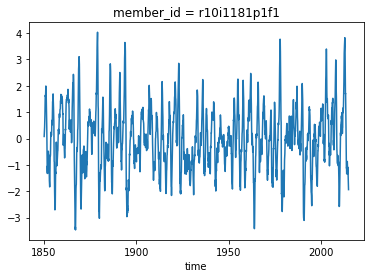

In [41]:
NINO34.plot()

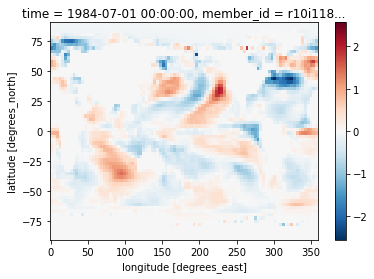

In [27]:
X_matrix_SST[1][0,:,:].plot()